# BELL STATE PREPARATION

In this hello-world tutorial we prepare a maximally entangled Bell state between two qubits, using both classical as well as actual quantum backends. For classical backends, we can run our circuit on a local Schroedinger simulator or a cloud-based tensor network simulator. For the quantum backends, we run our circuit on both the superconducting machine from Rigetti and the ion-trap machine provided by IonQ. As shown below, one can seamlessly swap between different backends without any modifications to the circuit definition, by just re-defining the device object. We also show how to recover results using the unique arn associated with every task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution. 

In [1]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate
from braket.devices import LocalSimulator
from braket.aws import AwsQuantumSimulator, AwsSession, AwsQpu, AwsQuantumTask, AwsQuantumSimulatorArns, AwsQpuArns

__NOTE__: Please enter your desired S3 location (bucket and key) below.

In [2]:
# set up S3 bucket (where results are stored)
my_bucket = "braket-bravehearts"
my_prefix = "simulation-output"
s3_folder = (my_bucket, my_prefix)

### Available Gates

First, let us check out the gate set currently supported by our SDK. Note that specific backends may only support a subset of these gates. You can retrieve this subset by calling ```device.properties['supportedQuantumOperations']```.

In [3]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:', gate_set)

Gate set supported by SDK: ['CCNot', 'CNot', 'CPhaseShift', 'CPhaseShift00', 'CPhaseShift01', 'CPhaseShift10', 'CSwap', 'CY', 'CZ', 'H', 'I', 'ISwap', 'PSwap', 'PhaseShift', 'Rx', 'Ry', 'Rz', 'S', 'Si', 'Swap', 'T', 'Ti', 'Unitary', 'V', 'Vi', 'X', 'XX', 'XY', 'Y', 'YY', 'Z', 'ZZ']


### Problem: Prepare Bell State

Goal: Prepare maximally entangled Bell state: 
$$\left|0,0\right> \rightarrow \left|\mathrm{Bell}\right> = \frac{1}{\sqrt{2}}\left(\left|0,0\right> + \left|1,1\right>\right).$$

To this end, we build and run the following circuit using a single-qubit Hadamard gate (denoted as ```H```) acting on the first qubit followed by a two-qubit ```CNOT``` gate: 
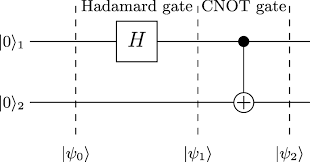

### Setup Circuit

In [66]:
# define circuit
bell = Circuit().h(0).cnot(0, 1)

In [67]:
# print circuit
print(bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


### Local Schroedinger Simulator

First we run our circuit locally, using an exact Schroedinger simulator. This local simulator is the preferred choice for fast experiments with low to intermediate qubit numbers ($N<20-25$) and essentially unlimited circuit depth. 

In [92]:
# set up backend: Local Schroedinger Simulator
device = LocalSimulator()

In [93]:
# run circuit (execute single TASK)
result = device.run(bell, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'11': 514, '00': 486})


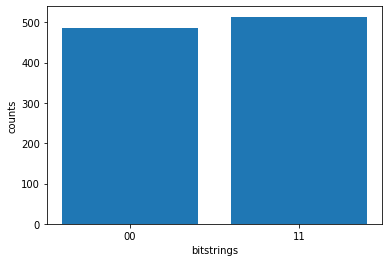

In [94]:
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

As opposed to quantum hardware, where we can only access measurement shots, with a classical simulator we can access the full statevector by simply calling ```result.state_vector```. This can be very useful for debugging. 

In [95]:
# print EXACT state vector
state_vector = result.state_vector
print('Full state vector:', state_vector)

Full state vector: {'00': (0.7071067811865475+0j), '01': 0j, '10': 0j, '11': (0.7071067811865475+0j)}


### Cloud-Based Schroedinger Simulator

As opposed to the local simulator above, we can also run our circuit against a cloud-based simulator. This approach adds some latency overhead, but may still be beneficial for larger circuits where memory optimized hardware can outperform a local machine.
Here, as part of the API call with ```run()``` you need to supply a S3 location where the metadata and results asscociated with this circuit execution will be stored.   

In [96]:
# set up TN backend
device = AwsQuantumSimulator(AwsQuantumSimulatorArns.QS1)

In [97]:
# bell = Circuit().h(0).cnot(0, 1)
result = device.run(bell, s3_folder).result()
counts = result.measurement_counts
print(counts)

Counter({'00': 509, '11': 491})


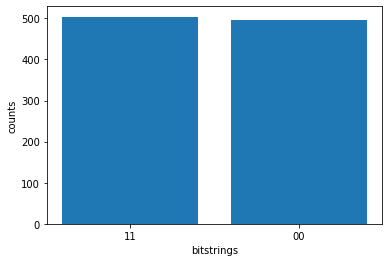

In [90]:
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

__NOTE__: Use unique task ID to look up task details in AWS console.

In [91]:
# print unique TASK ID (task = execution of individual circuit)
task_id = result.task_metadata['Id']
print('Task ID:', task_id)

Task ID: 6983e66a-447c-451c-a072-2f81700770c7


### Quantum Hardware: Rigetti

Next we submit our circuit to the superconducting quantum chip provided by Rigetti. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by provifing the unique ID assocaited with every task. 

In [14]:
# set backend
rigetti = AwsQpu(AwsQpuArns.RIGETTI)

# run circuit with a polling time of 5 days
rigetti_task = rigetti.run(bell, s3_folder, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

ID of task: arn:aws:aqx:us-west-1:465542368797:quantum-task:9ebf3397-19da-4d98-b49f-9b24751804d4
Status of task: INITIALIZED


The task is submitted and we can regulalry (or irregulalry) check the status of this task by executing the following cell. You may easily build logic around this query to wait for this task to complete before your code proceeds. 

In [45]:
# print status
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: COMPLETED


### Quantum Hardware: IonQ

Finally, we submit our example Bell state circuit to IonQ. To this end, we set the device backend as AwsQpu(AwsQpuArns.IONQ). This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task. 

In [17]:
# set backend
ionq = AwsQpu(AwsQpuArns.IONQ)

# run circuit with a polling time of 5 days
ionq_task = ionq.run(bell, s3_folder, poll_timeout_seconds=5*24*60*60)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

ID of task: arn:aws:aqx:us-east-1:465542368797:quantum-task:e6dad9c3-2631-4545-ba3c-923eec9f0353
Status of task: INITIALIZED


In [38]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

Status of (reconstructed) task: COMPLETED


### Task Recovery

By simply grabbing the unique task ID associated with the quantum tasks we have submitted above, we can recover this task at any point in time and (once the status is completed) visualize and analyze the corresponding results. 

Status of (reconstructed) task: COMPLETED
1000 shots taken on machine arn:aws:aqx:::qpu:rigetti.
Measurement counts: Counter({'00': 343, '10': 316, '11': 184, '01': 157})


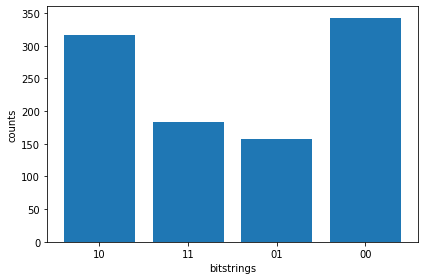

In [47]:
# recover task
task_load = AwsQuantumTask(arn=rigetti_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    rigetti_results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['backendArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    rigetti_counts = rigetti_results.measurement_counts
    print('Measurement counts:', rigetti_counts)

    # plot results: see effects of noise
    plt.bar(rigetti_counts.keys(), rigetti_counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('rigetti.png', dpi=700);
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

Status of (reconstructed) task: COMPLETED
1000 shots taken on machine arn:aws:aqx:::qpu:ionq.
Measurement counts: Counter({'00': 463, '11': 425, '01': 56, '10': 56})


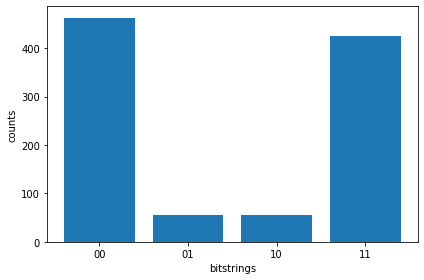

In [43]:
# recover task
task_load = AwsQuantumTask(arn=ionq_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['backendArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values());
    plt.xlabel('bitstrings');
    plt.ylabel('counts');
    plt.tight_layout();
    plt.savefig('bell_ionq.png', dpi=700);
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

We have succesfully recovered the results associated with the tasks that were queued up for the quantum hardware providers. Because of noise (decoherence) and other imperfections we cannot fully recover the exact results we have seen when using the classical simulators. To deal with that, in the fullness of time we will be able to use error correction techniques. As long as error correction is not available, it is important to benchamrk our quantum results using classical simualtors, whenever possible. 

---
# APPENDIX

Information on task:
 AwsQuantumTask('id':arn:aws:aqx:us-west-1:465542368797:quantum-task:4f36a7bb-46c6-4fa2-b6de-a835f97907da)
Status: INITIALIZED
Status: INITIALIZED
Status: QUEUED
Status: RUNNING
Status: COMPLETED
Status: COMPLETED
AwsQuantumTaskResult(measurements=array([[1, 0],
       [1, 1],
       [1, 1],
       ...,
       [1, 1],
       [0, 0],
       [0, 0]]), measurement_counts=Counter({'00': 510, '11': 422, '01': 44, '10': 24}), measurement_probabilities={'10': 0.024, '11': 0.422, '00': 0.51, '01': 0.044}, measurements_copied_from_device=True, measurement_counts_copied_from_device=False, measurement_probabilities_copied_from_device=False, task_metadata={'Id': '4f36a7bb-46c6-4fa2-b6de-a835f97907da', 'Status': 'COMPLETED', 'BackendArn': 'arn:aws:aqx:::qpu:rigetti', 'BackendTranslation': 'DECLARE ro BIT[2]\nH 0\nCNOT 0 1\nMEASURE 0 ro[0]\nMEASURE 1 ro[1]', 'Created': 1582060645.9389281, 'Modified': 1582060652.8518102, 'Shots': 1000, 'BackendParameters': {'GateModelParameters':

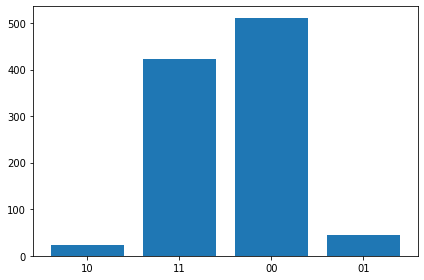

In [18]:
# set backend
rigetti = AwsQpu(AwsQpuArns.RIGETTI)

# run circuit with a polling time of 5 days
task = rigetti.run(bell, s3_folder, poll_timeout_seconds=5*24*60*60)
print('Information on task:\n', task)
print('==================================' * 2)

# get status of submitted task
status = task.state()

# wait for job to complete
terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
while status not in terminal_states:
    status = task.state()
    print('Status:', status)
    # time.sleep(60)

print('Status:', status)

# get results
rigetti_results = task.result()
print(rigetti_results)

# get measurement counts
rigetti_counts = rigetti_results.measurement_counts
print(rigetti_counts)

# plot results: see effects of noise
plt.bar(rigetti_counts.keys(), rigetti_counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');
plt.tight_layout();
plt.savefig('rigetti2.png', dpi=700);